In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics, neural_network, svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import itertools

In [2]:
sheep = np.load(r"data\full_numpy_bitmap_sheep.npy")
# print(sheep.shape)
giraffe = np.load(r"data\full_numpy_bitmap_giraffe.npy")
# print(giraffe.shape)
cat = np.load(r"data\full_numpy_bitmap_cat.npy")

sheep = sheep[:2000]
giraffe = giraffe[:2000]
cat = cat[:2000]

In [3]:
def combine_data(*args):
    X = np.zeros((0,784))
    Y = np.zeros((0,1))
    for i in range(len(args)):
        X = np.concatenate((X, args[i]))
        Y = np.concatenate((Y, np.ones((args[i].shape[0],1))*i))
    Y = Y.reshape(Y.shape[0])
    return X, Y

def split_data(X, Y, split=(0.8,0.1,0.1)):
    # defaulting to an 80/10/10 train/test/val split
    train, test, val = split
    X_train, X_testval, Y_train, Y_testval = train_test_split(X, Y, test_size=test+val, random_state=42, shuffle=True)
    X_test, X_val, Y_test, Y_val = train_test_split(X_testval, Y_testval, test_size=val/(test+val), random_state=42, shuffle=True)
    return X_train, X_test, X_val, Y_train, Y_test, Y_val

X, Y = combine_data(sheep, giraffe, cat)
X_train, X_test, X_val, Y_train, Y_test, Y_val = split_data(X, Y)

In [4]:
# alpha is the regularization parameter
# alphas = [0.0000001, 0.00001, 0.001, 0.01, 0.1, 1, 10, 100, 10000, 1000000]
# activation is the activation function for the hidden layer
# activations = ['logistic', 'tanh', 'relu']
# levels is the number of neurons in each hidden layer
# levels = [(60,), (60,20), (100,60,20)]


def create_classifier(X_train, Y_train, levels=(100,), activation='relu', alpha=0.0001):
    clf = neural_network.MLPClassifier(hidden_layer_sizes=levels, activation=activation, alpha=alpha, max_iter=1000)
    clf.fit(X_train, Y_train)
    return clf

SVC()

In [5]:
def accuracy(clf, X, Y):
    return clf.score(X, Y)

In [6]:
# testing normalization
def test_norms(X_train, Y_train, X_val, Y_val, normalizations):
    data = {"Normalization": [], "Accuracy": []}
    for norm in normalizations:
        if norm is not None:
            scaler = norm
            X_train_norm = scaler.fit_transform(X_train)
            X_val_norm = scaler.transform(X_val)
        else:
            X_train_norm = X_train
            X_val_norm = X_val
        classifier = create_classifier(X_train_norm, Y_train)
        acc = accuracy(classifier, X_val_norm, Y_val)
        data["Normalization"].append(norm)
        data["Accuracy"].append(acc)
    return pd.DataFrame(data)

# normalizations
normalizations = [None, StandardScaler(), MinMaxScaler()]
df = test_norms(X_train, Y_train, X_val, Y_val, normalizations)
print(df)

In [ ]:
def plot_regularization_scores(train_scores, val_scores, title):
    l1_penalties = [1e-7, 1e-5, 0.001, 0.01, 0.1, 1, 10, 100, 10000, 1000000]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(l1_penalties, train_scores, label='Train Score', marker='o')
    plt.plot(l1_penalties, val_scores, label='Validation Score', marker='o')
    plt.xscale('log')
    plt.xlabel('L1 Penalty')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()

    plt.tight_layout()
    plt.show()

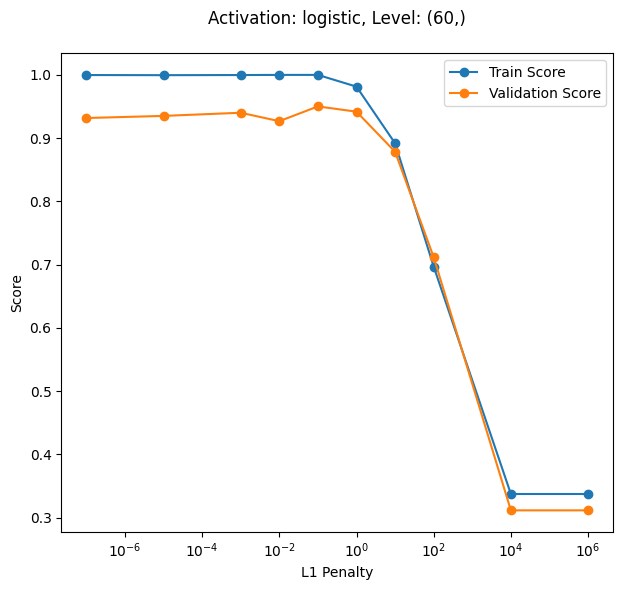

       C     train      test
0  10^-7  0.999583  0.931667
1  10^-5  0.999375  0.935000
2  10^-3  0.999583  0.940000
3  10^-2  0.999792  0.926667
4  10^-1  0.999792  0.950000
5   10^0  0.981250  0.941667
6   10^1  0.891667  0.878333
7   10^2  0.696875  0.711667
8   10^4  0.337500  0.311667
9   10^6  0.337500  0.311667


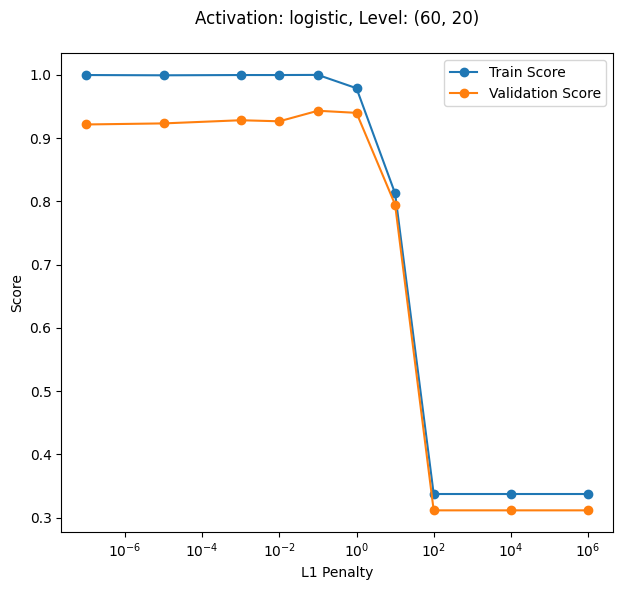

       C     train      test
0  10^-7  0.999792  0.921667
1  10^-5  0.999375  0.923333
2  10^-3  0.999792  0.928333
3  10^-2  0.999792  0.926667
4  10^-1  1.000000  0.943333
5   10^0  0.978958  0.940000
6   10^1  0.812708  0.795000
7   10^2  0.337500  0.311667
8   10^4  0.337500  0.311667
9   10^6  0.337500  0.311667


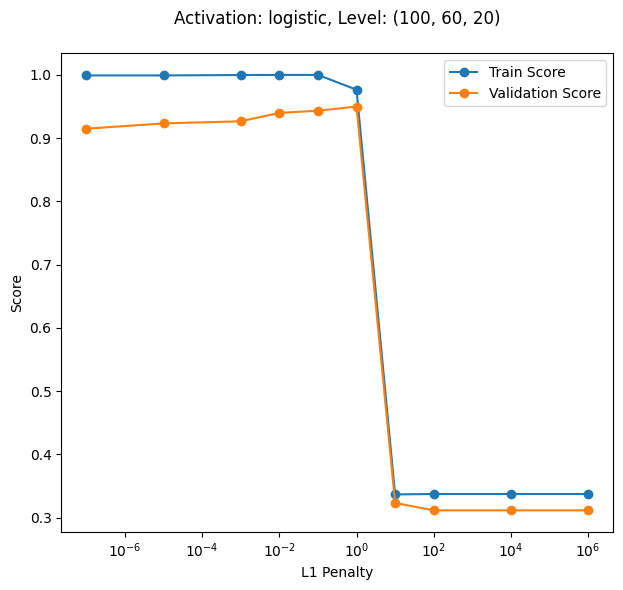

       C     train      test
0  10^-7  0.999167  0.915000
1  10^-5  0.999167  0.923333
2  10^-3  0.999792  0.926667
3  10^-2  1.000000  0.940000
4  10^-1  1.000000  0.943333
5   10^0  0.976667  0.950000
6   10^1  0.336875  0.323333
7   10^2  0.337500  0.311667
8   10^4  0.337500  0.311667
9   10^6  0.337500  0.311667


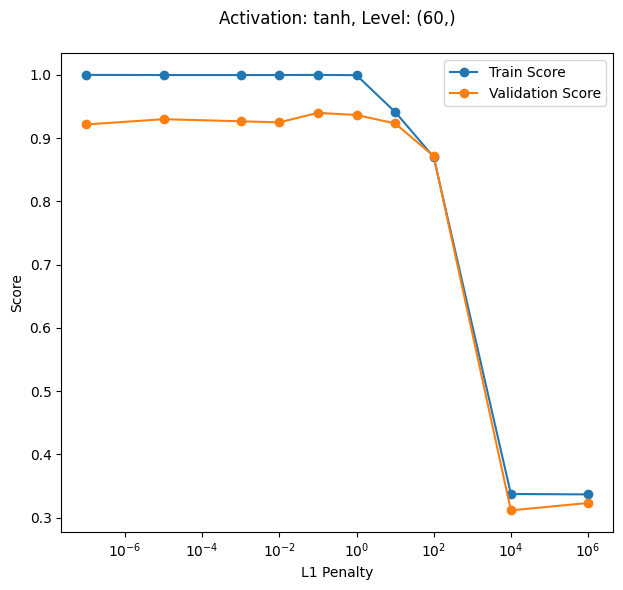

       C     train      test
0  10^-7  1.000000  0.921667
1  10^-5  0.999792  0.930000
2  10^-3  0.999792  0.926667
3  10^-2  0.999792  0.925000
4  10^-1  1.000000  0.940000
5   10^0  0.999583  0.936667
6   10^1  0.941458  0.923333
7   10^2  0.870208  0.871667
8   10^4  0.337500  0.311667
9   10^6  0.336875  0.323333


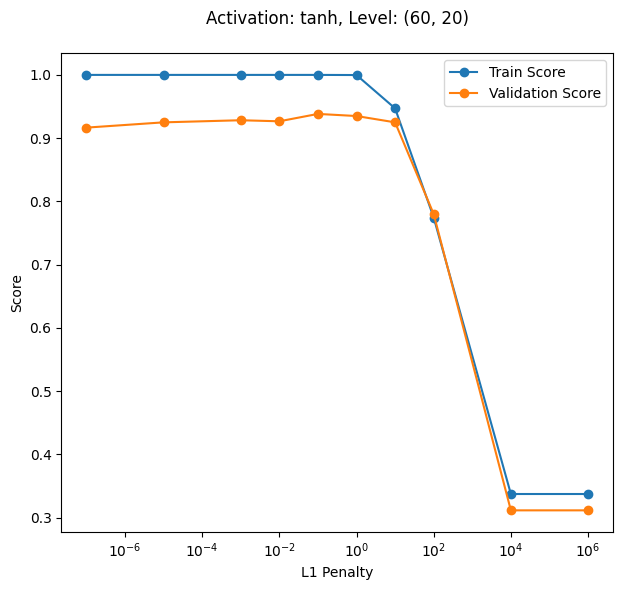

       C     train      test
0  10^-7  1.000000  0.916667
1  10^-5  1.000000  0.925000
2  10^-3  1.000000  0.928333
3  10^-2  1.000000  0.926667
4  10^-1  1.000000  0.938333
5   10^0  0.999792  0.935000
6   10^1  0.947083  0.925000
7   10^2  0.774583  0.780000
8   10^4  0.337500  0.311667
9   10^6  0.337500  0.311667


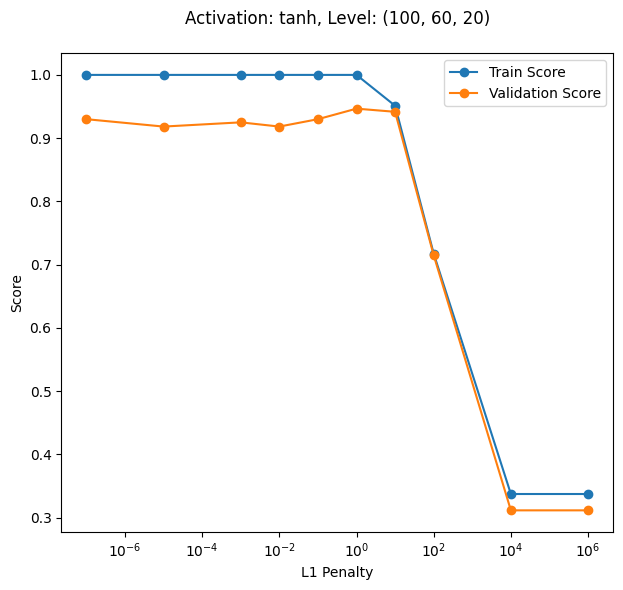

       C    train      test
0  10^-7  1.00000  0.930000
1  10^-5  1.00000  0.918333
2  10^-3  1.00000  0.925000
3  10^-2  1.00000  0.918333
4  10^-1  1.00000  0.930000
5   10^0  1.00000  0.946667
6   10^1  0.95125  0.941667
7   10^2  0.71750  0.715000
8   10^4  0.33750  0.311667
9   10^6  0.33750  0.311667


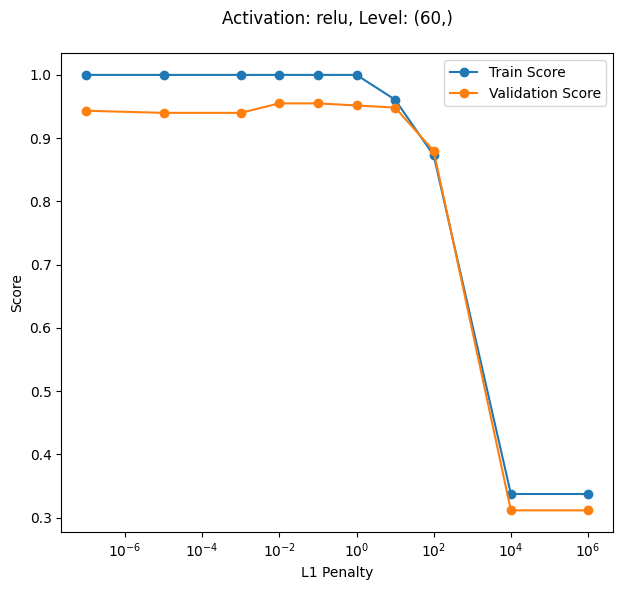

       C     train      test
0  10^-7  1.000000  0.943333
1  10^-5  1.000000  0.940000
2  10^-3  1.000000  0.940000
3  10^-2  1.000000  0.955000
4  10^-1  1.000000  0.955000
5   10^0  1.000000  0.951667
6   10^1  0.960833  0.948333
7   10^2  0.872917  0.880000
8   10^4  0.337500  0.311667
9   10^6  0.337500  0.311667


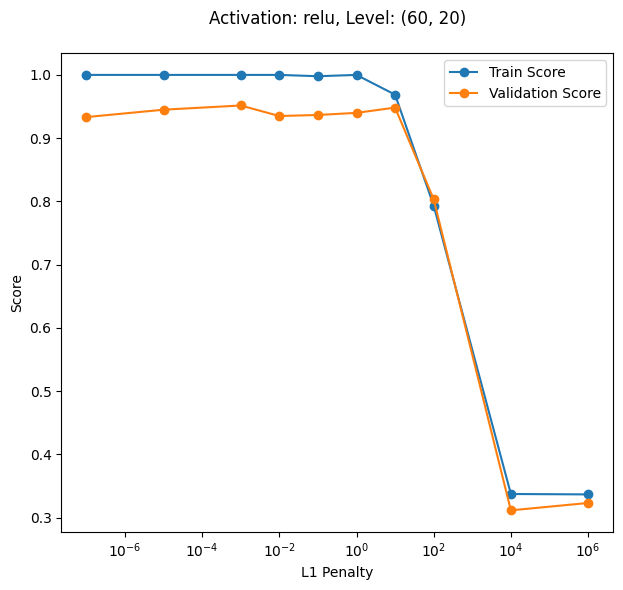

       C     train      test
0  10^-7  1.000000  0.933333
1  10^-5  1.000000  0.945000
2  10^-3  1.000000  0.951667
3  10^-2  1.000000  0.935000
4  10^-1  0.997917  0.936667
5   10^0  1.000000  0.940000
6   10^1  0.968750  0.948333
7   10^2  0.793333  0.803333
8   10^4  0.337500  0.311667
9   10^6  0.336875  0.323333


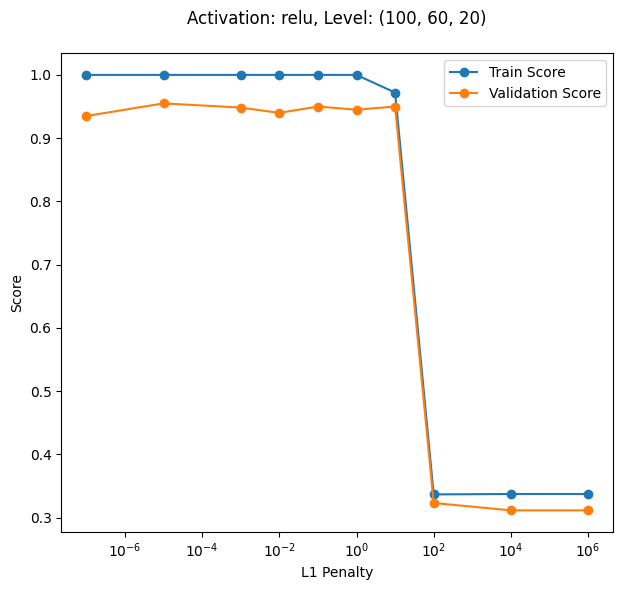

       C     train      test
0  10^-7  1.000000  0.935000
1  10^-5  1.000000  0.955000
2  10^-3  1.000000  0.948333
3  10^-2  1.000000  0.940000
4  10^-1  1.000000  0.950000
5   10^0  1.000000  0.945000
6   10^1  0.972083  0.950000
7   10^2  0.336875  0.323333
8   10^4  0.337500  0.311667
9   10^6  0.337500  0.311667


In [ ]:
# Testing C values (alphas)
def classify_and_df(X_tr, Y_tr, X_val, Y_val, activation, C_vals, levels, title):
    data = {"C": [], "train": [], "test": []}
    for C_val in C_vals:
        classifier = create_classifier(X_tr, Y_tr, levels=levels, activation=activation, alpha=C_val)
        acc_tr = accuracy(classifier, X_tr, Y_tr)
        acc_val = accuracy(classifier, X_val, Y_val)
        C_val_formatted = "10^" + str(int(np.log10(C_val)))
        data["C"].append(C_val_formatted)
        data["train"].append(acc_tr)
        data["test"].append(acc_val)
    plot_regularization_scores(data["train"], data["test"], title)
    return pd.DataFrame.from_dict(data)

def test_activation_levels(X_tr, Y_tr, X_val, Y_val, activations, C_vals, levels, scaler=None):
    # scale data
    X_train_scaled = scaler.fit_transform(X_tr) if scaler else X_tr
    X_val_scaled = scaler.transform(X_val) if scaler else X_val
    # for each activation function, test different C values and return dataframe storing C_vals and accuracy data
    for activation in activations:
        for level in levels:
            dataframe = classify_and_df(X_train_scaled, Y_train, X_val_scaled, Y_val, activation, C_vals, level, title=f"Activation: {activation}, Level: {level}\n")
            yield (activation, level, dataframe)

# testing different activation functions and hidden layer sizes
activations = ['logistic', 'tanh', 'relu']
levels = [(60,), (60,20), (100,60,20)]
C_vals = [0.0000001, 0.00001, 0.001, 0.01, 0.1, 1, 10, 100, 10000, 1000000]
with open("NN_results.csv", "w") as f:
    for activation, level, df in test_activation_levels(X_train, Y_train, X_val, Y_val, activations, C_vals, levels, scaler=StandardScaler()):
        # f.write(f"Activation: {activation}, Level: {level}\n")
        # df.to_csv(f, sep=',', encoding='utf-8', index=False, lineterminator='\n', columns=["C", "train", "test"])
        print(df)
        # f.write("\n")

0.92
Normalized confusion matrix
[[0.90825688 0.02293578 0.06880734]
 [0.00518135 0.95854922 0.03626943]
 [0.08465608 0.02116402 0.89417989]]


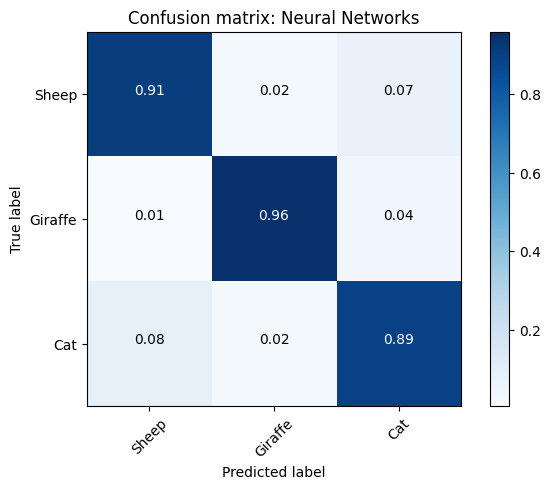

In [ ]:
def train_and_return_confusion_matrix(X_tr, Y_tr, X_test, Y_test, levels, activation, alpha, scaler=None):
    # scale data
    X_train_scaled = scaler.fit_transform(X_tr) if scaler else X_tr
    X_test_scaled = scaler.transform(X_test) if scaler else X_test
    # train classifier
    classifier = create_classifier(X_train_scaled, Y_tr, levels=levels, activation=activation, alpha=alpha)
    # return confusion matrix
    print(accuracy(classifier, X_test_scaled, Y_test))
    return metrics.confusion_matrix(Y_test, classifier.predict(X_test_scaled))

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix: Neural Networks', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# test with best parameters
cm = train_and_return_confusion_matrix(X_train, Y_train, X_test, Y_test, levels = (100,60,20), alpha=0.00001, activation='relu', scaler=MinMaxScaler())
plot_confusion_matrix(cm, ["Sheep", "Giraffe", "Cat"], normalize=True)